# CSC411 Assignment 3
Let's get it.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

## P1: Reading Data

In [3]:
import os
root_dir = os.path.join(os.getcwd(), "data")
fake_data = pd.read_fwf(os.path.join(root_dir, "clean_fake.txt"), header=None)
real_data = pd.read_fwf(os.path.join(root_dir, "clean_real.txt"), header=None)

In [4]:
print len(fake_data), len(real_data)

1298 1968


In [5]:
fake_train, fake_test = train_test_split(fake_data, test_size=0.15)
real_train, real_test = train_test_split(real_data, test_size=0.15)

fake_train, fake_validation = train_test_split(fake_train, test_size=0.15/0.85)
real_train, real_validation = train_test_split(real_train, test_size=0.15/0.85)

In [6]:
print len(fake_train), len(real_train)
print type(fake_train)

908 1376
<class 'pandas.core.frame.DataFrame'>


In [10]:
fake_train[:10]

,0
930,us officials fbi see no link between trump and...
481,the resentments trump represents
311,comment on what is causing the strange trumpet...
824,comment on new breed of crisis actors fake pol...
251,how donald trump changed the world of dating
294,trump unleashes on media everyone at cnn is a ...
752,mr trump here is a worthy perhaps final opport...
1218,trump new ad portraying every mother worse nig...
1257,the toronto star published an unauthorized dat...
1099,ukraine congratulates trump god bless america


In [9]:
real_train[:10]

,0
1841,donald trump holds back some jfk assassination...
1669,tpp trade pact dead buried cremated amid trump...
1106,donald trump travel ban gets response from mal...
302,julia gillard beyond blue chair on donald trump
1480,is it fair to call trump a fascist
1411,donald trump orders review of post gfc regulat...
17,trumps team says we are behind but can still w...
141,who is george papadopoulos the former trump ca...
448,trump delays meeting with turnbull to spruik a
1828,will president trumps us tax cuts deliver anyt...


## P2: Naive Bayes

In [7]:
def generate_counts(data):
    '''
    data is an array of strings
    '''
    counts = {}
    for line in data:
        words = line.split(" ")
        for word in words:
            if word in counts:
                counts[word] += 1.0
            else:
                counts[word] = 1.0
    return counts

In [8]:
fake_counts = generate_counts(fake_train[0])
real_counts = generate_counts(real_train[0])

fake_vocab = fake_counts.keys()
real_vocab = real_counts.keys()

fake_vocab_size = len(fake_vocab)
real_vocab_size = len(real_vocab)

for word in fake_counts.keys():
    if word not in real_counts:
        real_counts[word] = 0.0
for word in real_counts.keys():
    if word not in fake_counts:
        fake_counts[word] = 0.0

total_counts = {}
for word in real_counts.keys():
    total_counts[word] = real_counts[word] + fake_counts[word]
    
total_vocab_size = len(total_counts)

num_fake = float(len(fake_train))
num_real = float(len(real_train))
num_total = num_fake + num_real

P_real = num_real / num_total
P_fake = num_fake / num_total

prior = 7.99e-6 
m = 151800
fake_thetas = {word: (fake_counts[word] + m * prior) / (num_fake + m) for word in fake_counts.keys()}      #gives P(x | fake)
real_thetas = {word: (real_counts[word] + m * prior) / (num_real + m) for word in real_counts.keys()}      #gives P(x | real)
total_thetas = {word: (total_counts[word] + m * prior) / (num_total + m) for word in total_counts.keys()}  #gives P(x)

In [108]:
def make_prediction(line):
    '''
    line is a string
    '''
    words = line.split(" ")
    log_P_words_given_real = 0
    log_P_words_given_fake = 0
    for word in real_thetas.keys():
      
        if word in words:
            log_P_words_given_real += np.log(real_thetas[word]) 
            log_P_words_given_fake += np.log(fake_thetas[word])
        else:
            log_P_words_given_real += np.log(1 - real_thetas[word])
            log_P_words_given_fake += np.log(1 - fake_thetas[word])
    
    
    log_numerator = log_P_words_given_real + np.log(P_real)
    numerator = np.exp(log_numerator)
    
    log_fake = log_P_words_given_fake + np.log(P_fake)
    log_denominator = np.log(numerator + np.exp(log_fake))
    
    log_P_real_given_words = log_numerator - log_denominator
    return np.exp(log_P_real_given_words)

In [153]:
class NaiveBayes(object):
    def __init__(self, prior=1e-5, m=1e6):
        self.prior = prior
        self.m = m
        
    def fit(self, fake, real):
        fake_counts = self._generate_counts(fake)
        real_counts = self._generate_counts(real)

        fake_vocab = fake_counts.keys()
        real_vocab = real_counts.keys()

        fake_vocab_size = len(fake_vocab)
        real_vocab_size = len(real_vocab)

        for word in fake_counts.keys():
            if word not in real_counts:
                real_counts[word] = 0.0
        for word in real_counts.keys():
            if word not in fake_counts:
                fake_counts[word] = 0.0

        num_fake = float(len(fake_train))
        num_real = float(len(real_train))
        num_total = num_fake + num_real

        self.P_real = num_real / num_total
        self.P_fake = num_fake / num_total
        
        self.fake_thetas = {word: (fake_counts[word] + self.m * self.prior) / (num_fake + self.m) for word in fake_counts.keys()}      #gives P(x | fake)
        self.real_thetas = {word: (real_counts[word] + self.m * self.prior) / (num_real + self.m) for word in real_counts.keys()}      #gives P(x | real)
        self.total_thetas = {word: (total_counts[word] + self.m * self.prior) / (num_total + self.m) for word in total_counts.keys()}  #gives P(x)

    def predict(self, line, probability=True):
        words = line.split(" ")
        log_P_words_given_real = 0
        log_P_words_given_fake = 0
        for word in self.real_thetas.keys():
            if word in words:
                log_P_words_given_real += np.log(self.real_thetas[word]) 
                log_P_words_given_fake += np.log(self.fake_thetas[word])
            else:
                log_P_words_given_real += np.log(1 - self.real_thetas[word])
                log_P_words_given_fake += np.log(1 - self.fake_thetas[word])

        log_numerator = log_P_words_given_real + np.log(self.P_real)
        numerator = np.exp(log_numerator)

        log_fake = log_P_words_given_fake + np.log(self.P_fake)
        log_denominator = np.log(numerator + np.exp(log_fake))

        log_P_real_given_words = log_numerator - log_denominator
        prob = np.exp(log_P_real_given_words)
        return prob if probability else int(round(prob)) 
    
    def score(self, X, y):
        predictions = []
        for line in X:
            predictions.append(self.predict(line, probability=False))
        accuracy = np.mean(np.equal(np.array(predictions), y.astype(int)).astype(int))
        return accuracy
    
    def _generate_counts(self, data):
        '''
        data is an array of strings
        '''
        counts = {}
        for line in data:
            words = line.split(" ")
            for word in words:
                if word in counts:
                    counts[word] += 1.0
                else:
                    counts[word] = 1.0
        return counts

In [155]:
clf = NaiveBayes()
clf.fit(fake_train[0], real_train[0])
clf.predict("fcc chairman ajit pai attempted to take a pornstar out for dinner", False)

1

In [9]:
train = np.row_stack((np.column_stack((fake_train[0], np.zeros(len(fake_train)))), \
                      np.column_stack((real_train[0], np.ones(len(real_train))))))
X_train = train[:, 0]
y_train = train[:, 1]

In [10]:
valid = np.row_stack((np.column_stack((fake_validation[0], np.zeros(len(fake_validation)))), \
                      np.column_stack((real_validation[0], np.ones(len(real_validation))))))
X_valid = valid[:, 0]
y_valid = valid[:, 1]

In [11]:
test = np.row_stack((np.column_stack((fake_test[0], np.zeros(len(fake_test)))), \
                      np.column_stack((real_test[0], np.ones(len(real_test))))))
X_test = test[:, 0]
y_test = test[:, 1]

In [159]:
clf.score(X_train, y_train)

0.8918563922942206

In [161]:
clf.score(X_valid, y_valid)

0.8105906313645621

In [192]:
all_priors = []
accuracies = []
virtual_sizes = {}

In [194]:
priors = 10**np.random.uniform(low=-9.0, high=-4.0, size=25)
m_sizes = 10**np.random.uniform(low=9.0, high=4.0, size=10)
for m in m_sizes:
    virtual_sizes[m] = {'priors': [], 'accuracies': []}
    for prior in priors:
        virtual_sizes[m]['priors'].append(prior)
        clf = NaiveBayes(prior, m)
        clf.fit(fake_train[0], real_train[0])
        virtual_sizes[m]['accuracies'].append(clf.score(X_valid, y_valid))


In [172]:
import matplotlib.pyplot as plt
%matplotlib inline

In [197]:
def plot_accuracies(priors, accuracies, m):
    plt.figure(figsize=(12,9))
    plt.title("Validation Accuracies for Various Priors \nwith {} additional virtual examples".format(m))
    plt.xlabel("Priors")
    plt.ylabel("Accuracy")
    plt.xscale('log')
    plt.ylim(0.6, 1.0)
    plt.scatter(priors, accuracies, marker='x')
    plt.savefig("./figures/accuracies_naive_bayes_m{}.png".format(m), dpi=300, bbox_inches='tight')

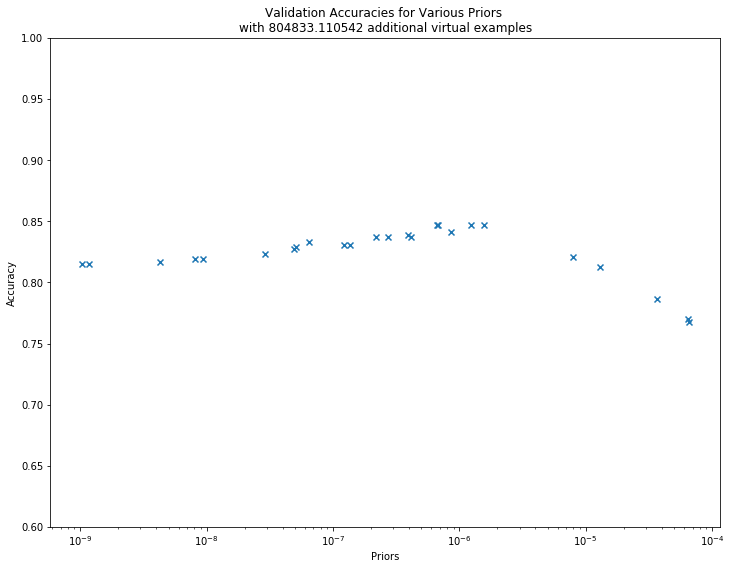

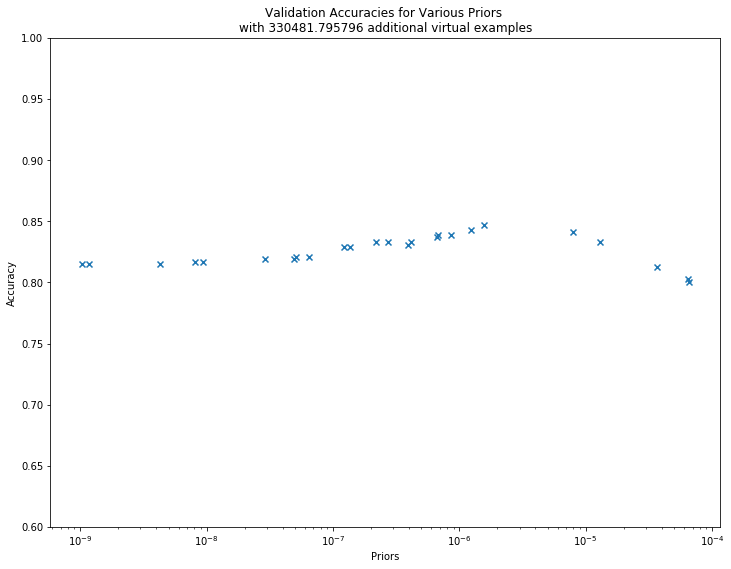

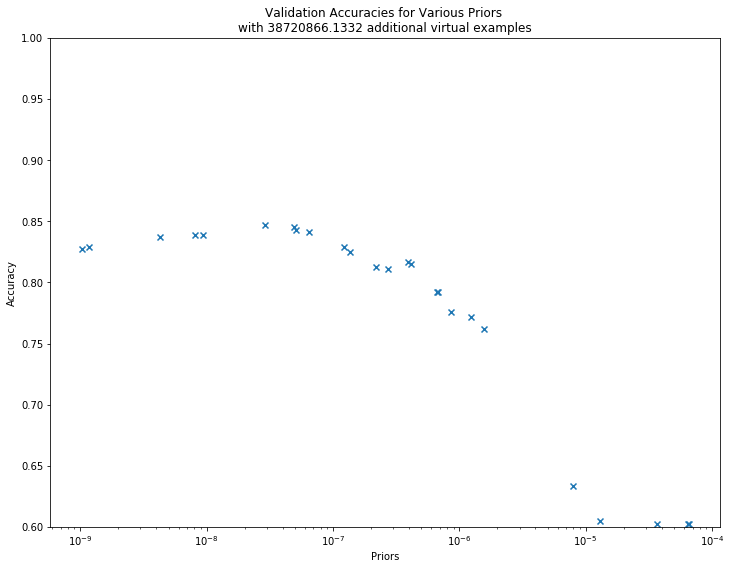

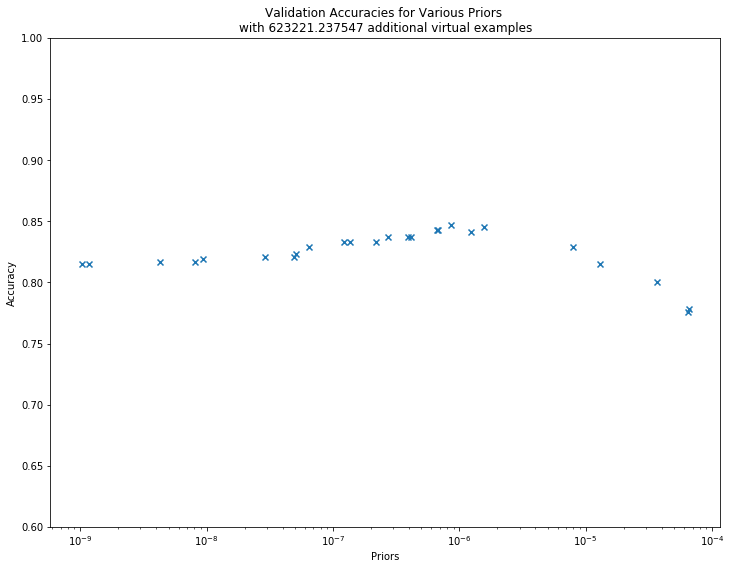

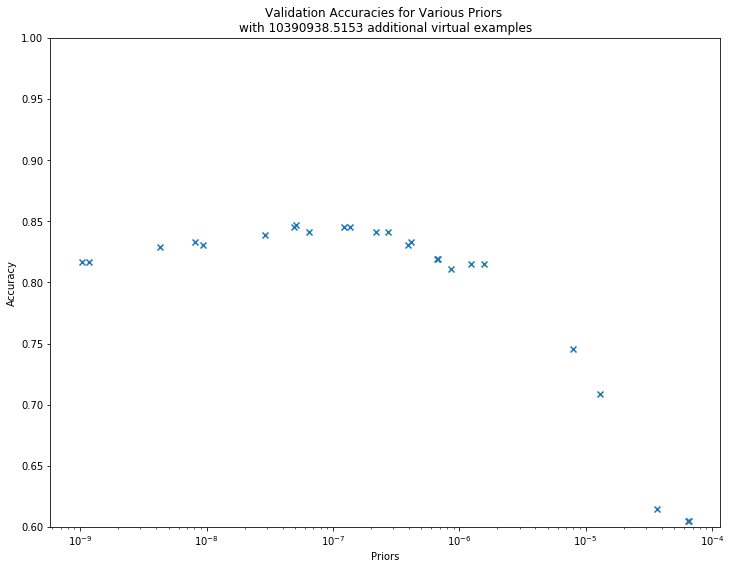

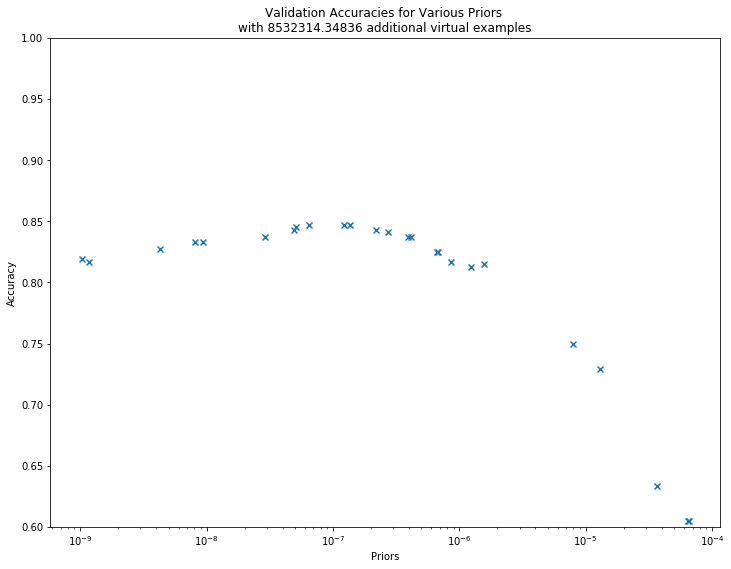

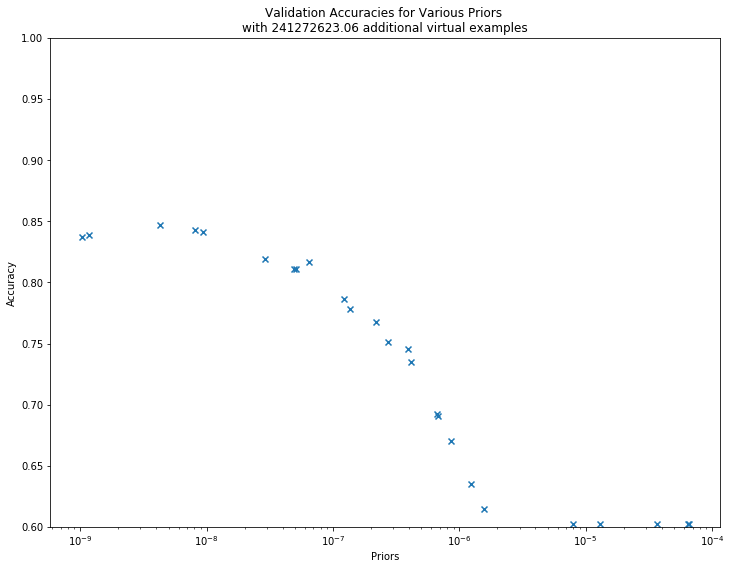

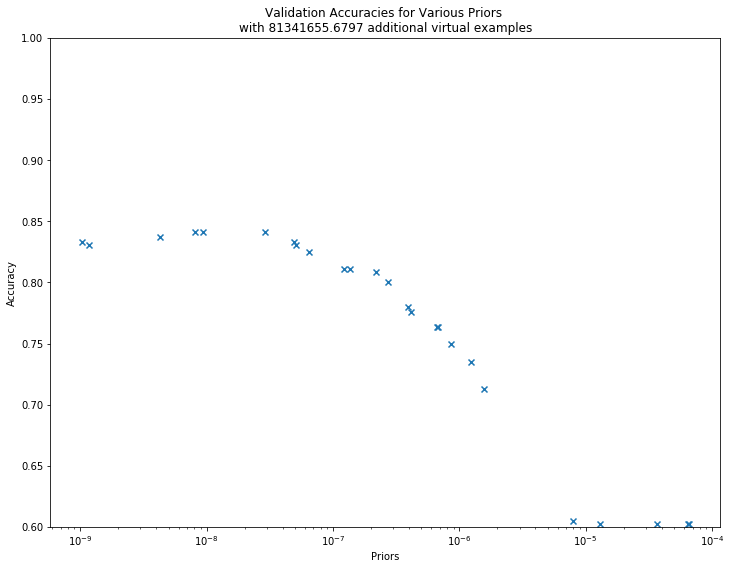

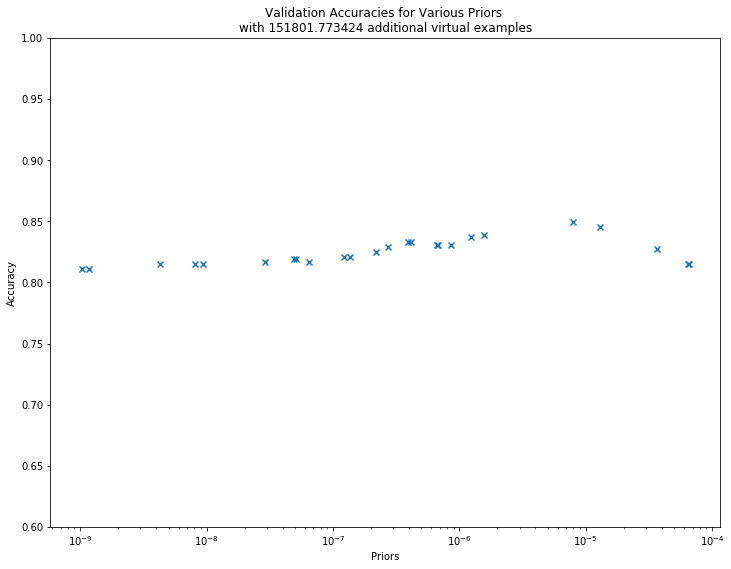

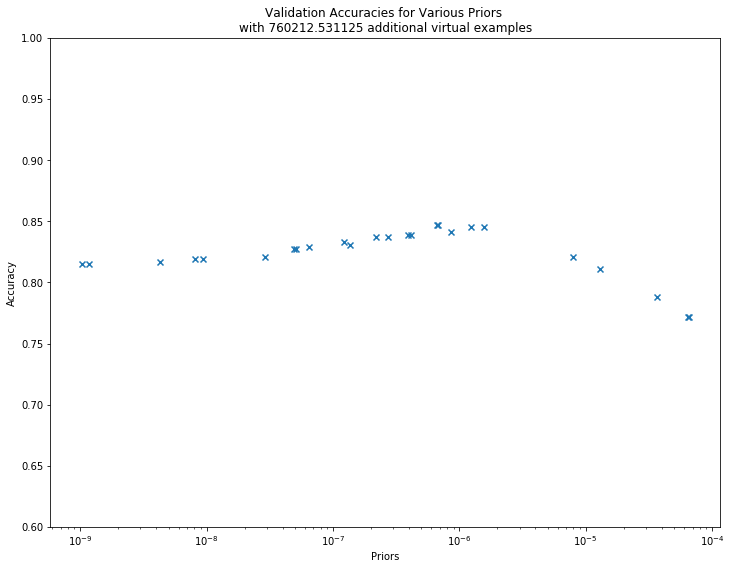

In [206]:
for m, data in virtual_sizes.items():
    if len(data["priors"]) != len(data["accuracies"]): continue
    plot_accuracies(data["priors"], data["accuracies"], m)

In [209]:
best_accuracy = 0
best_m = None
best_p = None
for m, data in virtual_sizes.items():
    if len(data["priors"]) != len(data["accuracies"]): continue
    for i, prior in enumerate(data["priors"]):
        accuracy = data["accuracies"][i]
        if accuracy > best_accuracy:
            best_m = m
            best_p = prior
            best_accuracy = accuracy

In [211]:
print best_m, best_p, best_accuracy

151801.77342401978 7.987523752417999e-06 0.8492871690427699


In [213]:
best_clf = NaiveBayes(best_p, best_m)
best_clf.fit(fake_train[0], real_train[0])
train_accuracy = best_clf.score(X_train, y_train)
valid_accuracy = best_clf.score(X_valid, y_valid)
test_accuracy = best_clf.score(X_test, y_test)
print train_accuracy, valid_accuracy, test_accuracy

0.9492119089316988 0.8492871690427699 0.8411405295315683


## Part 3: Word Analysis

In [224]:
# Goal: max P(real | word) = max P(word | read) * P(real)
# = max P(word | real) = max real_thetas
real_thetas_ = [(word, theta) for word, theta in real_thetas.items()]
sorted_real_words = sorted(real_thetas_, key=lambda pair: pair[1], reverse=True)
sorted_real_words[:10]

[('trump', 0.00798566930850786),
 ('donald', 0.0038270543818875024),
 ('to', 0.0018946367707734892),
 ('us', 0.0010394114090980311),
 ('trumps', 0.0009806554682195644),
 ('in', 0.000928427965216483),
 ('of', 0.0009218995273410979),
 ('on', 0.0009088426515903275),
 ('the', 0.0008696720243380165),
 ('says', 0.0008500867107118609)]

In [225]:
# Goal: max P(real | not word) = max P(not word | read) * P(real)
# = max P(not word | real) = max (1 - P(word | real)) = max (1 - real_thetas)
real_thetas_ = [(word, theta) for word, theta in real_thetas.items()]
sorted_real_words_not = sorted(real_thetas_, key=lambda pair: 1 - pair[1], reverse=True)
sorted_real_words_not[:10]

[('hats', 7.918224787172926e-06),
 ('child', 7.918224787172926e-06),
 ('pide', 7.918224787172926e-06),
 ('sleep', 7.918224787172926e-06),
 ('battleground', 7.918224787172926e-06),
 ('assembled', 7.918224787172926e-06),
 ('whose', 7.918224787172926e-06),
 ('vandal', 7.918224787172926e-06),
 ('edward', 7.918224787172926e-06),
 ('lord', 7.918224787172926e-06)]

In [226]:
# But now look at words that only actually appear in the real headlines
real_thetas_ = [(word, theta) for word, theta in real_thetas.items() if word in real_vocab]
sorted_real_words_not = sorted(real_thetas_, key=lambda pair: 1 - pair[1], reverse=True)
sorted_real_words_not[:10]

[('pardon', 1.4446662662558104e-05),
 ('manaforts', 1.4446662662558104e-05),
 ('asian', 1.4446662662558104e-05),
 ('hanging', 1.4446662662558104e-05),
 ('pheasant', 1.4446662662558104e-05),
 ('hasan', 1.4446662662558104e-05),
 ('hate', 1.4446662662558104e-05),
 ('votes', 1.4446662662558104e-05),
 ('voter', 1.4446662662558104e-05),
 ('groundwork', 1.4446662662558104e-05)]

In [227]:
# Goal: max P(fake | word) = max P(word | fake) * P(fake)
# = max P(word | fake) = max fake_thetas
fake_thetas_ = [(word, theta) for word, theta in fake_thetas.items()]
sorted_fake_words = sorted(fake_thetas_, key=lambda pair: pair[1], reverse=True)
sorted_fake_words[:10]

[('trump', 0.006065254485685099),
 ('the', 0.001992121447468371),
 ('to', 0.0019593792204730598),
 ('in', 0.0010556937554024675),
 ('donald', 0.001016403083008094),
 ('of', 0.0009574670744165335),
 ('for', 0.0009247248474212222),
 ('a', 0.0008592403934305997),
 ('on', 0.000819949721036226),
 ('and', 0.0007675621578437278)]

In [228]:
# Goal: max P(fake | not word) = max P(not word | fake) * P(fake)
# = max P(not word | fake) = max 1 - fake_thetas
fake_thetas_ = [(word, theta) for word, theta in fake_thetas.items()]
sorted_fake_words_not = sorted(fake_thetas_, key=lambda pair: 1 - pair[1], reverse=True)
sorted_fake_words_not[:10]

[('personally', 7.942491552505435e-06),
 ('asian', 7.942491552505435e-06),
 ('liar', 7.942491552505435e-06),
 ('paris', 7.942491552505435e-06),
 ('nominates', 7.942491552505435e-06),
 ('risk', 7.942491552505435e-06),
 ('commerce', 7.942491552505435e-06),
 ('govern', 7.942491552505435e-06),
 ('affect', 7.942491552505435e-06),
 ('exporters', 7.942491552505435e-06)]

In [222]:
fake_thetas_ = [(word, theta) for word, theta in fake_thetas.items() if word in fake_vocab]
sorted_fake_words_not = sorted(fake_thetas_, key=lambda pair: 1 - pair[1], reverse=True)
sorted_fake_words_not[:10]

[('hats', 1.0990021060876724e-05),
 ('temperament', 1.0990021060876724e-05),
 ('pide', 1.0990021060876724e-05),
 ('four', 1.0990021060876724e-05),
 ('sleep', 1.0990021060876724e-05),
 ('deri', 1.0990021060876724e-05),
 ('hating', 1.0990021060876724e-05),
 ('liar', 1.0990021060876724e-05),
 ('assembled', 1.0990021060876724e-05),
 ('pointing', 1.0990021060876724e-05)]

### Part 3 b)

In [14]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
real_thetas_ = [(word, theta) for word, theta in real_thetas.items() if word not in ENGLISH_STOP_WORDS]
sorted_real_words = sorted(real_thetas_, key=lambda pair: pair[1], reverse=True)
sorted_real_words[:10]

[('trump', 0.007933441805504779),
 ('donald', 0.0037552415652582654),
 ('trumps', 0.0010459398469734162),
 ('says', 0.0008305013970857053),
 ('election', 0.000412681373061054),
 ('clinton', 0.000412681373061054),
 ('ban', 0.000340868556431817),
 ('north', 0.000340868556431817),
 ('president', 0.00032781168068104664),
 ('korea', 0.0003212832428056615)]

In [15]:
fake_thetas_ = [(word, theta) for word, theta in fake_thetas.items() if word not in ENGLISH_STOP_WORDS]
sorted_fake_words = sorted(fake_thetas_, key=lambda pair: pair[1], reverse=True)
sorted_fake_words[:10]

[('trump', 0.006032512258689787),
 ('donald', 0.0010753390915996543),
 ('hillary', 0.0006693354768577939),
 ('clinton', 0.0005383665688765487),
 ('just', 0.00038775232469811664),
 ('election', 0.00037465543389999216),
 ('new', 0.0003550100977028054),
 ('obama', 0.00028952564371218274),
 ('president', 0.00026333186211593366),
 ('america', 0.00026333186211593366)]

## Part 7: Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [17]:
sorted_combined = sorted_real_words[:500] + sorted_fake_words[:500]
important_vocab = list(set([word for word, _ in sorted_combined]))

In [18]:
def feature_extraction(titles, important_vocab):
    X = np.zeros([len(titles), len(important_vocab)])
    for i, title in enumerate(titles):
        words = title.split(" ")
        for word in words:
            if word in important_vocab:
                j = important_vocab.index(word)
                X[i,j] += 1
    return X

In [22]:
X_train_fake = feature_extraction(fake_train[0], important_vocab)
X_train_real = feature_extraction(real_train[0], important_vocab)
X_train = np.row_stack((X_train_fake, X_train_real))

y_train_fake = np.zeros([len(fake_train), 1])
y_train_real = np.ones([len(real_train), 1])
y_train = np.row_stack((y_train_fake, y_train_real))


train = np.column_stack((X_train, y_train))
np.random.seed(411)
np.random.shuffle(train)
X_train = train[:,:-1]
y_train = train[:,-1]
print X_train.shape
print y_train.shape

(2284, 811)
(2284,)


In [35]:
X_valid_fake = feature_extraction(fake_validation[0], important_vocab)
X_valid_real = feature_extraction(real_validation[0], important_vocab)
X_valid = np.row_stack((X_valid_fake, X_valid_real))

y_valid_fake = np.zeros([len(fake_validation), 1])
y_valid_real = np.ones([len(real_validation), 1])
y_valid = np.row_stack((y_valid_fake, y_valid_real))


valid = np.column_stack((X_valid, y_valid))
np.random.seed(411)
np.random.shuffle(valid)
X_valid = valid[:,:-1]
y_valid = valid[:,-1]
print X_valid.shape
print y_valid.shape

(491, 811)
(491,)


In [36]:
X_test_fake = feature_extraction(fake_test[0], important_vocab)
X_test_real = feature_extraction(real_test[0], important_vocab)
X_test = np.row_stack((X_test_fake, X_test_real))

y_test_fake = np.zeros([len(fake_test), 1])
y_test_real = np.ones([len(real_test), 1])
y_test = np.row_stack((y_test_fake, y_test_real))


test = np.column_stack((X_test, y_test))
np.random.seed(411)
np.random.shuffle(test)
X_test = test[:,:-1]
y_test = test[:,-1]
print X_test.shape
print y_test.shape

(491, 811)
(491,)


In [270]:
all_depths = []
train_accuracies = []
valid_accuracies = []

In [272]:
max_depths = np.random.randint(low=1, high=100, size=50)
for depth in max_depths:
    print "Max Depth: {}".format(depth)
    all_depths.append(depth)
    
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train, y_train)
    
    train_accuracy = tree_clf.score(X_train, y_train)
    valid_accuracy = tree_clf.score(X_valid, y_valid)
    
    print "Train Accuracy: {:.4}, Validation Accuracy: {:.4}".format(train_accuracy, valid_accuracy)
    
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

Max Depth: 19
Train Accuracy: 0.7859, Validation Accuracy: 0.7088
Max Depth: 54
Train Accuracy: 0.9076, Validation Accuracy: 0.7169
Max Depth: 20
Train Accuracy: 0.7951, Validation Accuracy: 0.7006
Max Depth: 30
Train Accuracy: 0.8507, Validation Accuracy: 0.7108
Max Depth: 78
Train Accuracy: 0.9282, Validation Accuracy: 0.7067
Max Depth: 33
Train Accuracy: 0.859, Validation Accuracy: 0.7169
Max Depth: 34
Train Accuracy: 0.8612, Validation Accuracy: 0.721
Max Depth: 12
Train Accuracy: 0.7404, Validation Accuracy: 0.6864
Max Depth: 59
Train Accuracy: 0.9146, Validation Accuracy: 0.723
Max Depth: 33
Train Accuracy: 0.8586, Validation Accuracy: 0.7169
Max Depth: 10
Train Accuracy: 0.7172, Validation Accuracy: 0.6782
Max Depth: 8
Train Accuracy: 0.7032, Validation Accuracy: 0.668
Max Depth: 58
Train Accuracy: 0.9137, Validation Accuracy: 0.723
Max Depth: 9
Train Accuracy: 0.7137, Validation Accuracy: 0.6782
Max Depth: 35
Train Accuracy: 0.8643, Validation Accuracy: 0.723
Max Depth: 20
Trai

In [262]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def plot_accuracies(depths, vocab_size, **accuracies):
    plt.figure(figsize=(12,9))
    plt.title("Training and Validation Accuracies for Various Max Depths\nand a vocab size of {}".format(vocab_size))
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    for dataset, accuracy in accuracies.items():
        plt.scatter(depths, accuracy, label=dataset, marker='x')
    plt.legend()
    plt.savefig("./figures/accuracies_vocab_size_{}.png".format(vocab_size), dpi=300, bbox_inches='tight')

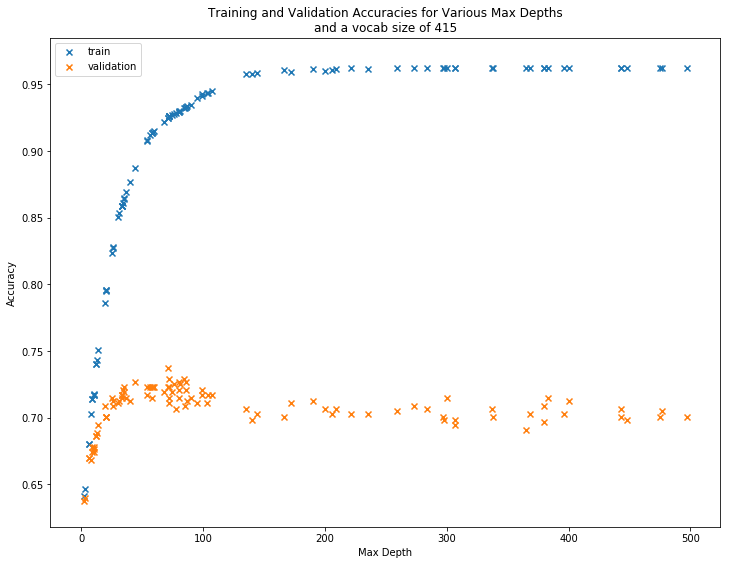

In [273]:
vocab_size = len(important_vocab)
accuracies = {'train': train_accuracies, "validation": valid_accuracies}
plot_accuracies(all_depths, vocab_size, **accuracies)

#### Other Hyperparameters:

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from time import time

In [27]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}\n".format(results['params'][candidate]))
            if i == 1:
                best_params = results['params'][candidate]
    return best_params

In [28]:
np.random.seed(411)
param_dist = {"max_depth": sp_randint(low=25,high=500),
              "max_features": sp_randint(low=25, high=300),
              "min_samples_split": sp_randint(low=3, high=8),
              "min_samples_leaf": sp_randint(low=1, high=6),
              "criterion": ["gini", "entropy"]}
n_iter_search=300
clf = DecisionTreeClassifier()

In [29]:
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search)

In [30]:
X = np.row_stack((X_train, X_valid))
y = np.row_stack((y_train.reshape(-1,1), y_valid.reshape(-1,1)))

In [31]:
start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
best_params = report(random_search.cv_results_)

RandomizedSearchCV took 43.11 seconds for 300 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.764 (std: 0.019)
Parameters: {'max_features': 147, 'min_samples_split': 4, 'criterion': 'entropy', 'max_depth': 401, 'min_samples_leaf': 2}

Model with rank: 1
Mean validation score: 0.764 (std: 0.003)
Parameters: {'max_features': 90, 'min_samples_split': 7, 'criterion': 'entropy', 'max_depth': 377, 'min_samples_leaf': 3}

Model with rank: 3
Mean validation score: 0.763 (std: 0.009)
Parameters: {'max_features': 51, 'min_samples_split': 6, 'criterion': 'gini', 'max_depth': 139, 'min_samples_leaf': 1}



In [32]:
best_tree_clf = DecisionTreeClassifier(**best_params)
best_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=377,
            max_features=90, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=7,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [37]:
train_accuracy = best_tree_clf.score(X_train, y_train)
valid_accuracy = best_tree_clf.score(X_valid, y_valid)
test_accuracy = best_tree_clf.score(X_test, y_test)
print train_accuracy, valid_accuracy, test_accuracy

0.8401926444833625 0.7617107942973523 0.7617107942973523


### Part 7 b) Visualization

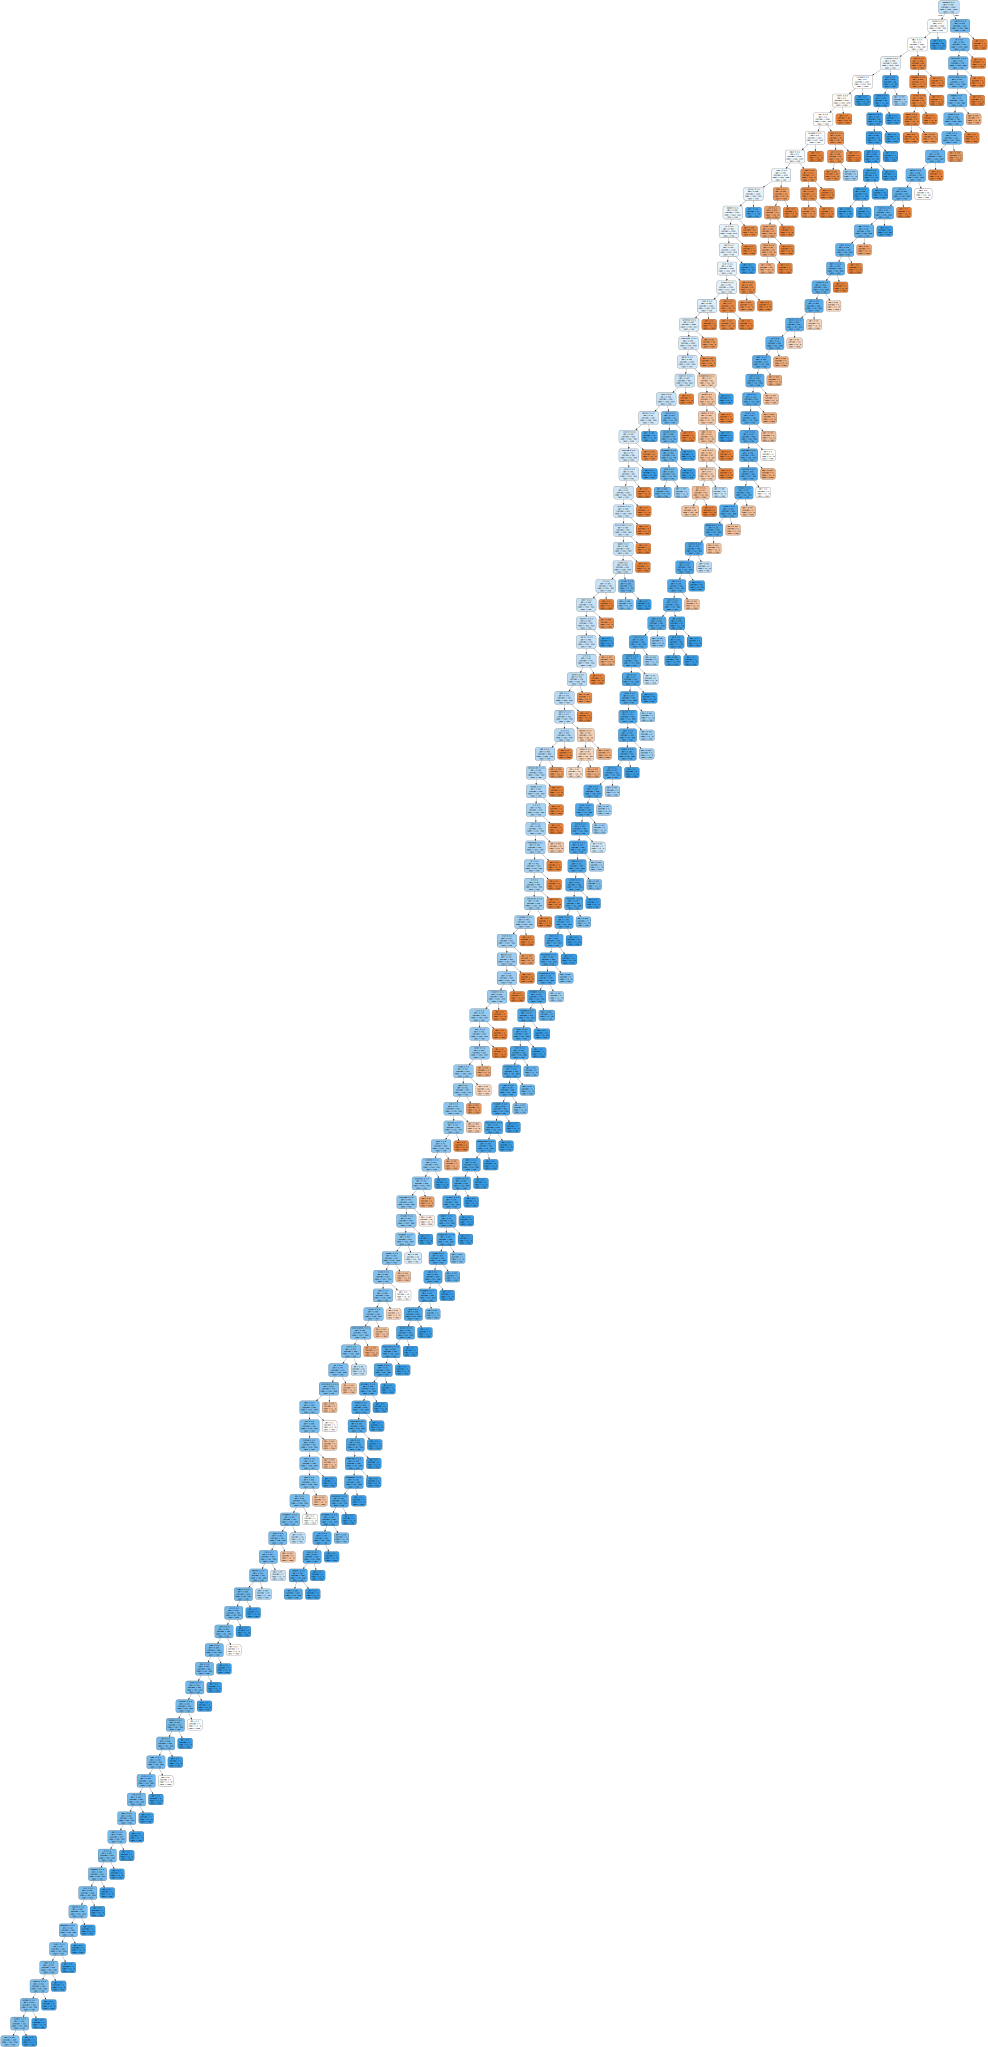

In [350]:
from sklearn.tree import export_graphviz
import graphviz
graph_data = export_graphviz(best_tree_clf, out_file=None, 
                             feature_names=important_vocab,
                            class_names=["fake", "real"],
                            filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(graph_data)
graph

## Part 8

In [472]:
top_word = "vote"
P_word_given_real = (real_counts[top_word] + prior * m) / (num_real + m)
P_word_given_fake = (fake_counts[top_word] + prior * m) / (num_fake + m)

P_word = (total_counts[top_word] + prior * m) / (num_total + m)
P_real_given_word = P_word_given_real * P_real / P_word
P_fake_given_word = P_word_given_fake * P_fake / P_word

H_word = -(P_word*np.log2(P_word) + (1-P_word)*np.log2(1-P_word))

H_word_given_class = P_real * (-(P_word_given_real * np.log2(P_word_given_real) + (1-P_word_given_real)*np.log2(1 - P_word_given_real))) \
                        + P_fake * (-(P_word_given_fake * np.log2(P_word_given_fake) + (1-P_word_given_fake) * np.log2(1 - P_word_given_fake)))
    
mutual_info_word_class = H_word - H_word_given_class
print mutual_info_word_class

0.0017794194971282166


In [462]:
from sklearn.feature_selection import mutual_info_classif

results = dict(zip(important_vocab, mutual_info_classif(X_train, y_train, n_neighbors=1, random_state=411)))
results["donald"]

0.030140084539550208